#### Print your name

In [1]:
## Your code here 
print("Exercise by: Janne Bragge.")

Exercise by: Janne Bragge.


# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np

import sys
sys.path.insert(0, '../answers')
import helper

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.


***
### Exercise:
Define needed transforms for training images and testing images.

**Use parameters:**
- mini-batch size = 64
- Use normalization 

In [3]:
## Task 1:
## Your code here 


# Määritetään normalisointi ImageNet-malleille
data_normalization = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Koulutusdatassa käytetään augmentointia + normalisointia
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    data_normalization
])

# Testidatassa vain resize ja normalisointi
test_transforms = transforms.Compose([
    transforms.Resize(256, antialias="warn"),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    data_normalization
])

# Ladataan datasetit
train_data = datasets.ImageFolder("/home/jovyan/shared/Cat_Dog_data/train", transform=train_transforms)
test_data = datasets.ImageFolder("/home/jovyan/shared/Cat_Dog_data/test", transform=test_transforms)

# Luodaan DataLoaderit batch-koolla 64
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)



***
We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [4]:
model = models.densenet121(weights='DEFAULT')
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [5]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [6]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)

True
2.4.1+cu121


In [7]:
import time

In [8]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 2.856 seconds
Device = cuda; Time per batch: 0.013 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.



***
### Exercise: 
Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

**Use following parameters:**
- Print train loss, test loss and test accuracy after every mini-batch
- Run training only 35 mini-batches (=64*35=2240 images)
- Save result to following parameters: 
`train_losses, test_losses, test_accuracies = [], [], []`


In [9]:
## Task 2:
## Your code here

# Muokataan luokittelukerros (Classifier)
model.classifier = nn.Sequential(
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(256, 2),  # Kaksi luokkaa: kissa ja koira
    nn.LogSoftmax(dim=1)
)

# Määritetään optimointialgoritmi ja tappiofunktio
criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

# Ladataan esikoulutettu DenseNet-malli
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Koulutusparametrit
train_losses, test_losses, test_accuracies = [], [], []
train_batches = 35

# Koulutussilmukka
for batch_idx, (images, labels) in enumerate(trainloader):
    if batch_idx >= train_batches:
        break  # Pysäytetään 35 mini-erän jälkeen
    
    model.train()
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    
    start_time = time.time()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_time = time.time() - start_time
    
    train_losses.append(loss.item())
    print(f"Train time [s]: {train_time:.6f} | Step {batch_idx+1}/{train_batches} - Train Loss: {loss.item():.4f}")
    
    # Testaussilmukka jokaisen mini-erän jälkeen
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    test_losses.append(test_loss / len(testloader))
    test_accuracies.append(correct / total)
    test_time = time.time() - start_time
    print(f"Test time [s]: {test_time:.6f} | Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]*100:.2f}%") 

Train time [s]: 0.081854 | Step 1/35 - Train Loss: 0.7200
Test time [s]: 26.612665 | Test Loss: 0.3594, Test Accuracy: 95.52%
Train time [s]: 0.073175 | Step 2/35 - Train Loss: 0.4395
Test time [s]: 26.008825 | Test Loss: 0.4730, Test Accuracy: 72.53%
Train time [s]: 0.036557 | Step 3/35 - Train Loss: 0.5610
Test time [s]: 26.706177 | Test Loss: 0.2872, Test Accuracy: 87.72%
Train time [s]: 0.035639 | Step 4/35 - Train Loss: 0.5347
Test time [s]: 26.099563 | Test Loss: 0.1819, Test Accuracy: 93.56%
Train time [s]: 0.036155 | Step 5/35 - Train Loss: 0.1907
Test time [s]: 26.030971 | Test Loss: 0.1073, Test Accuracy: 97.36%
Train time [s]: 0.037800 | Step 6/35 - Train Loss: 0.1694
Test time [s]: 25.911141 | Test Loss: 0.1026, Test Accuracy: 96.96%
Train time [s]: 0.039445 | Step 7/35 - Train Loss: 0.2369
Test time [s]: 25.921530 | Test Loss: 0.0973, Test Accuracy: 96.96%
Train time [s]: 0.039474 | Step 8/35 - Train Loss: 0.2066
Test time [s]: 26.953408 | Test Loss: 0.0757, Test Accuracy:

But still the network makes mistakes... 

***

### Exercise: 
Print 8 pictures of errors (with test images) in dog/cat -classification.
- save 8. image index to `last_index`
- save erroneous images to `error_images`

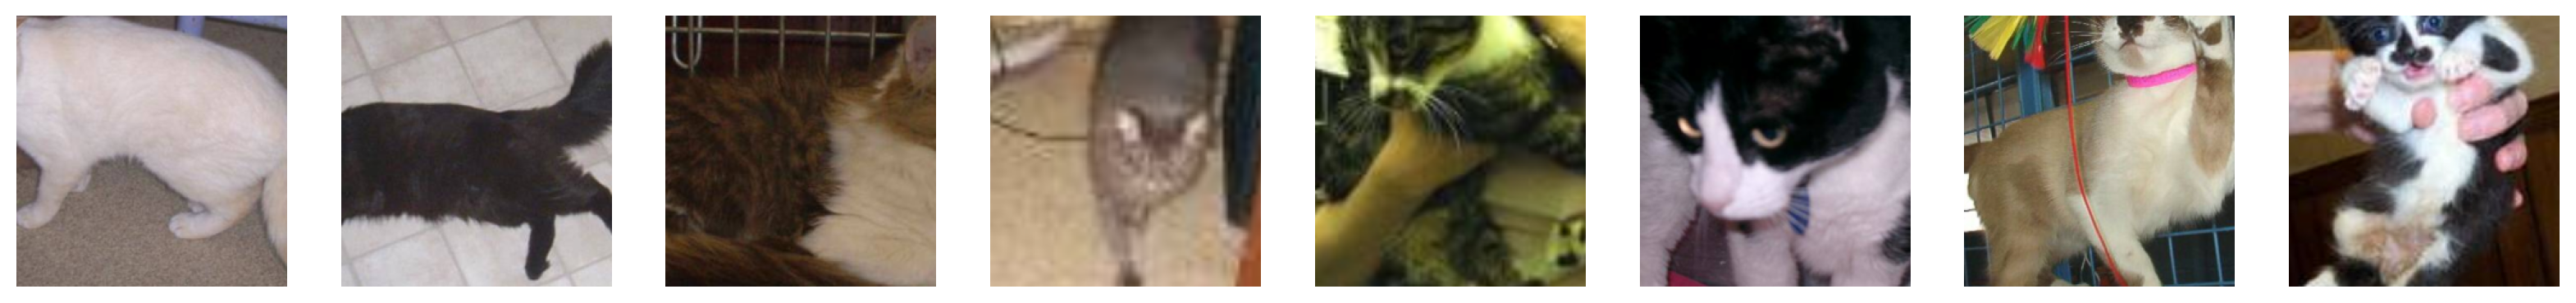

Batch 1 Image 27 [False] Prediction [1] Label 0
Batch 1 Image 45 [False] Prediction [1] Label 0
Batch 1 Image 49 [False] Prediction [1] Label 0
Batch 2 Image 61 [False] Prediction [1] Label 0
Batch 3 Image 17 [False] Prediction [1] Label 0
Batch 3 Image 27 [False] Prediction [1] Label 0
Batch 3 Image 31 [False] Prediction [1] Label 0
Batch 3 Image 35 [False] Prediction [1] Label 0
Batch 3 Image 47 [False] Prediction [1] Label 0
192 images checked to find 9 errors.
Accuracy: 0.953125


In [10]:
## Task 3:
## Your code here 

# Ladataan esikoulutettu malli ja asetetaan laite
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Muuttujat virheellisille kuville
error_images = []
error_details = []
last_index = None
incorrect_count = 0

# Testataan mallia ja kerätään virheellisesti luokitellut kuvat
checked_images = 0
correct_predictions = 0

total_samples = len(testloader.dataset)

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Etsitään virheelliset ennusteet
        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in incorrect_indices:
            error_images.append(images[idx].cpu())
            error_details.append(f"Batch {batch_idx+1} Image {idx.item()} [False] Prediction [{predicted[idx].item()}] Label {labels[idx].item()}")
            incorrect_count += 1
            if incorrect_count == 8:
                last_index = batch_idx * testloader.batch_size + idx.item()
        
        # Päivitetään tarkistetut ja oikeat
        checked_images += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        if incorrect_count >= 8:
            break

# Näytetään 8 virheellisesti luokiteltua kuvaa
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for i, img in enumerate(error_images[:8]):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean  # Palautetaan normalisoitu kuva alkuperäiseksi
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

# Tulostetaan virheellisten kuvien tiedot
for detail in error_details:
    print(detail)

# Tulostetaan lopullinen tarkkuus
accuracy = correct_predictions / checked_images
print(f"{checked_images} images checked to find {incorrect_count} errors.")
print(f"Accuracy: {accuracy:.6f}")
 

***

## Reflection

Answer briefly following questions (in English or Finnish):

**What is CUDA?**

CUDA (Compute Unified Device Architecture) is a technology created by NVIDIA that lets programmers use graphics cards (GPUs) to speed up computing tasks. Instead of only handling graphics, GPUs can run thousands of small tasks at the same time, making them much faster than regular CPUs for things like AI, video processing, and scientific simulations. (NVIDIA, 2023)
  
**Why GPU is faster than CPU?**

GPUs are faster than CPUs because they process many tasks at the same time. They have thousands of small cores working together, while CPUs have only a few powerful cores. GPUs also move data quickly with high memory bandwidth. They are great for graphics, AI, and big calculations. CPUs are better for tasks that need quick decisions and complex logic. (Sanders & Kandrot, 2010)


**How many pre-trained image network can you find from torchvision models?**

Check the next cell for the answer

**What kind of pictures network mislabels? Are those still easy for a human to classify?**

Based on the notebook, neural networks often mislabel images when an animal is captured from an unusual angle, making it difficult to recognize. Misclassification can also happen if the image contains both a cat and a dog or includes people, causing confusion. Another common issue occurs when the animal is not fully visible, such as only part of its body being shown. Despite these challenges, humans can still correctly classify most of these mislabeled images, as they have a better ability to understand context and recognize patterns.

-----------------
References

NVIDIA. (2023). CUDA C Programming Guide (Release 12.3). Retrieved from CUDA documentation.

Sanders, J., & Kandrot, E. (2010). CUDA by Example: An Introduction to General-Purpose GPU Programming. Addison-Wesley Professiona


In [11]:
import torchvision.models as models

# Hae kaikki käytettävissä olevat mallit
all_models = models.list_models()

# Tulosta mallit siistissä muodossa
print("How many pre-trained image network can you find from torchvision models?\n\n Available pre-trained networks:")
for i, model_name in enumerate(all_models, start=1):
    print(f"{i}. {model_name}")


How many pre-trained image network can you find from torchvision models?

 Available pre-trained networks:
1. alexnet
2. convnext_base
3. convnext_large
4. convnext_small
5. convnext_tiny
6. deeplabv3_mobilenet_v3_large
7. deeplabv3_resnet101
8. deeplabv3_resnet50
9. densenet121
10. densenet161
11. densenet169
12. densenet201
13. efficientnet_b0
14. efficientnet_b1
15. efficientnet_b2
16. efficientnet_b3
17. efficientnet_b4
18. efficientnet_b5
19. efficientnet_b6
20. efficientnet_b7
21. efficientnet_v2_l
22. efficientnet_v2_m
23. efficientnet_v2_s
24. fasterrcnn_mobilenet_v3_large_320_fpn
25. fasterrcnn_mobilenet_v3_large_fpn
26. fasterrcnn_resnet50_fpn
27. fasterrcnn_resnet50_fpn_v2
28. fcn_resnet101
29. fcn_resnet50
30. fcos_resnet50_fpn
31. googlenet
32. inception_v3
33. keypointrcnn_resnet50_fpn
34. lraspp_mobilenet_v3_large
35. maskrcnn_resnet50_fpn
36. maskrcnn_resnet50_fpn_v2
37. maxvit_t
38. mc3_18
39. mnasnet0_5
40. mnasnet0_75
41. mnasnet1_0
42. mnasnet1_3
43. mobilenet_v2
44

*Your answers here...*

### Check your answers by running following cell:

Train:
Dataset ImageFolder
    Number of datapoints: 22500
    Root location: /home/jovyan/shared/Cat_Dog_data/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Compose(
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Mini-batch size: 64
Traindata loader: 22528


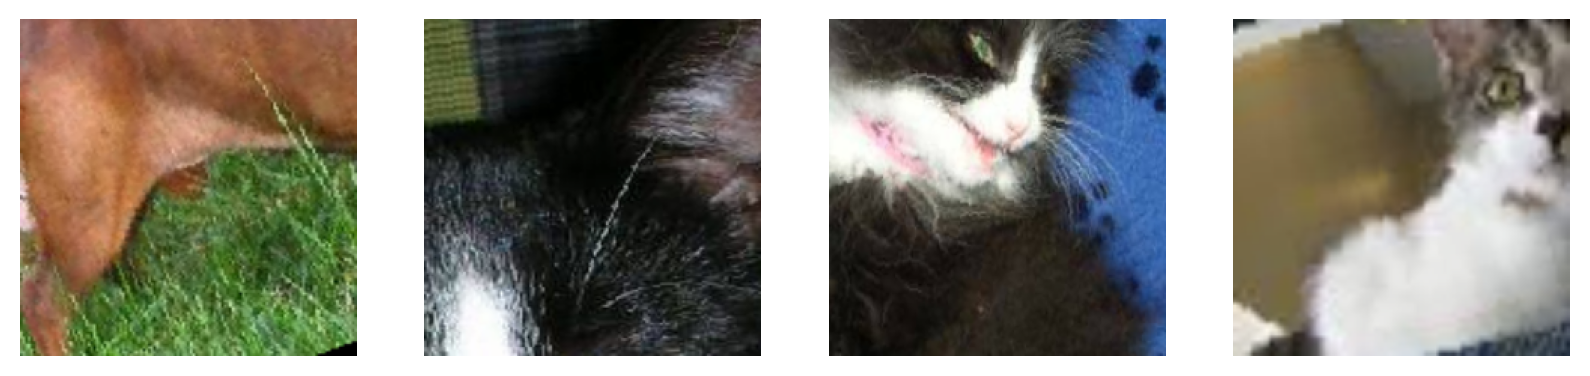

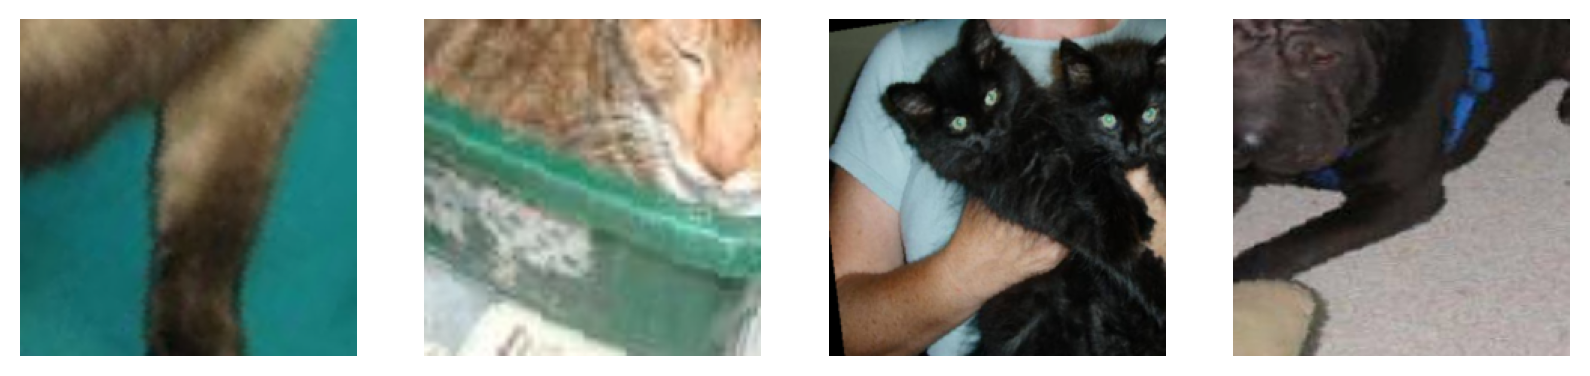

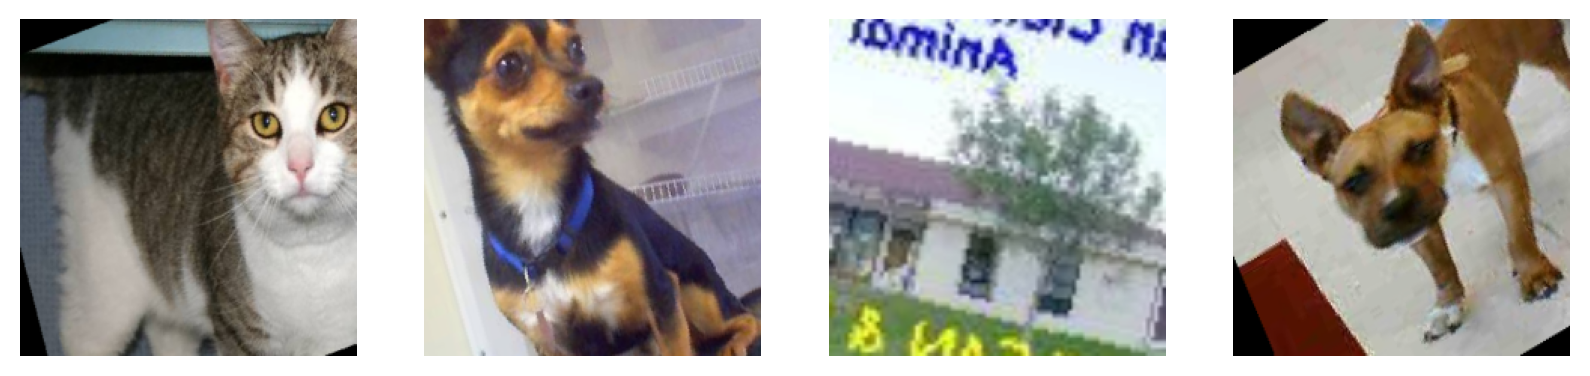

In [12]:
# Do not change this code!

print("Train:")
print(train_data)
print(train_transforms)
print("Mini-batch size:", trainloader.batch_size)
print("Traindata loader:", len(trainloader)*trainloader.batch_size)
for ii in range(3):
    data_iter = iter(trainloader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(figsize=(10,4), ncols=4)
    for ii in range(4):
        ax = axes[ii]
        helper.imshow(images[ii], ax=ax, normalize=True)

Test:
Dataset ImageFolder
    Number of datapoints: 2501
    Root location: /home/jovyan/shared/Cat_Dog_data/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Mini-batch size: 64
Traindata loader: 2560


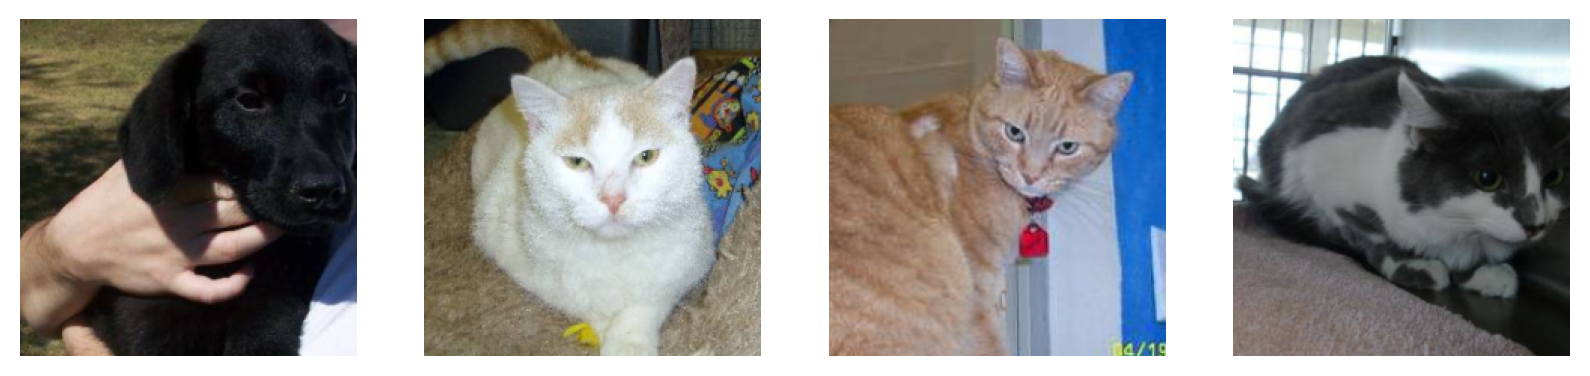

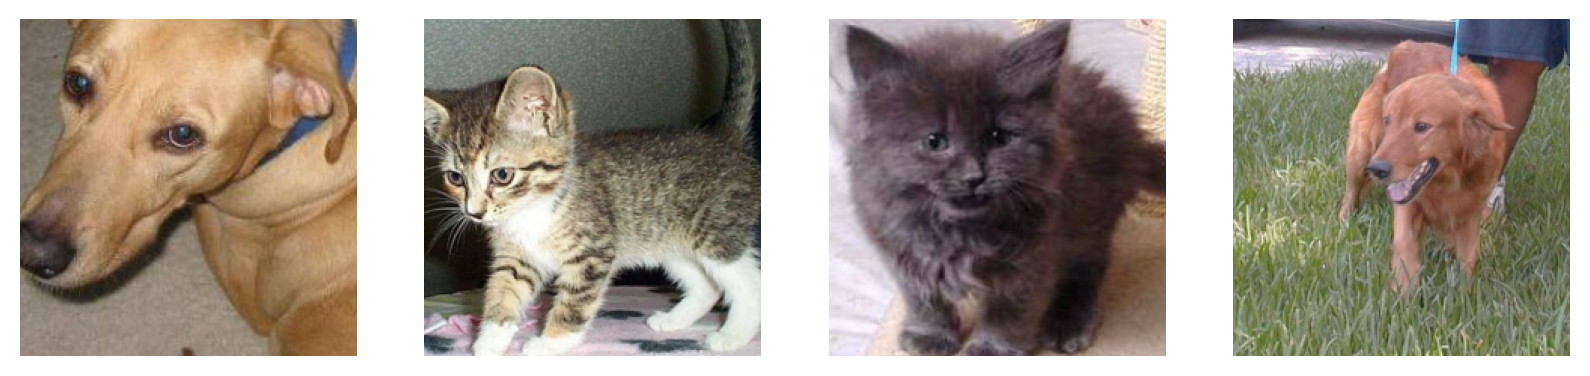

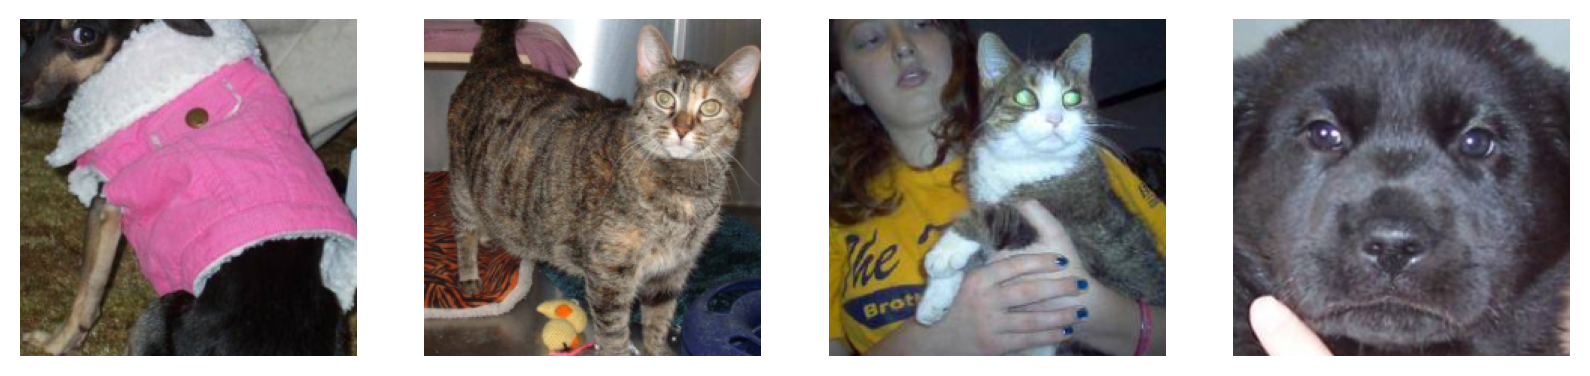

In [13]:
# Do not change this code!

print("Test:")
print(test_data)
print(test_transforms)
print("Mini-batch size:", testloader.batch_size)
print("Traindata loader:", len(testloader)*testloader.batch_size)
for ii in range(3):
    data_iter = iter(testloader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(figsize=(10,4), ncols=4)
    for ii in range(4):
        ax = axes[ii]
        helper.imshow(images[ii], ax=ax, normalize=True)

In [14]:
model.features

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke

In [15]:
model.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)

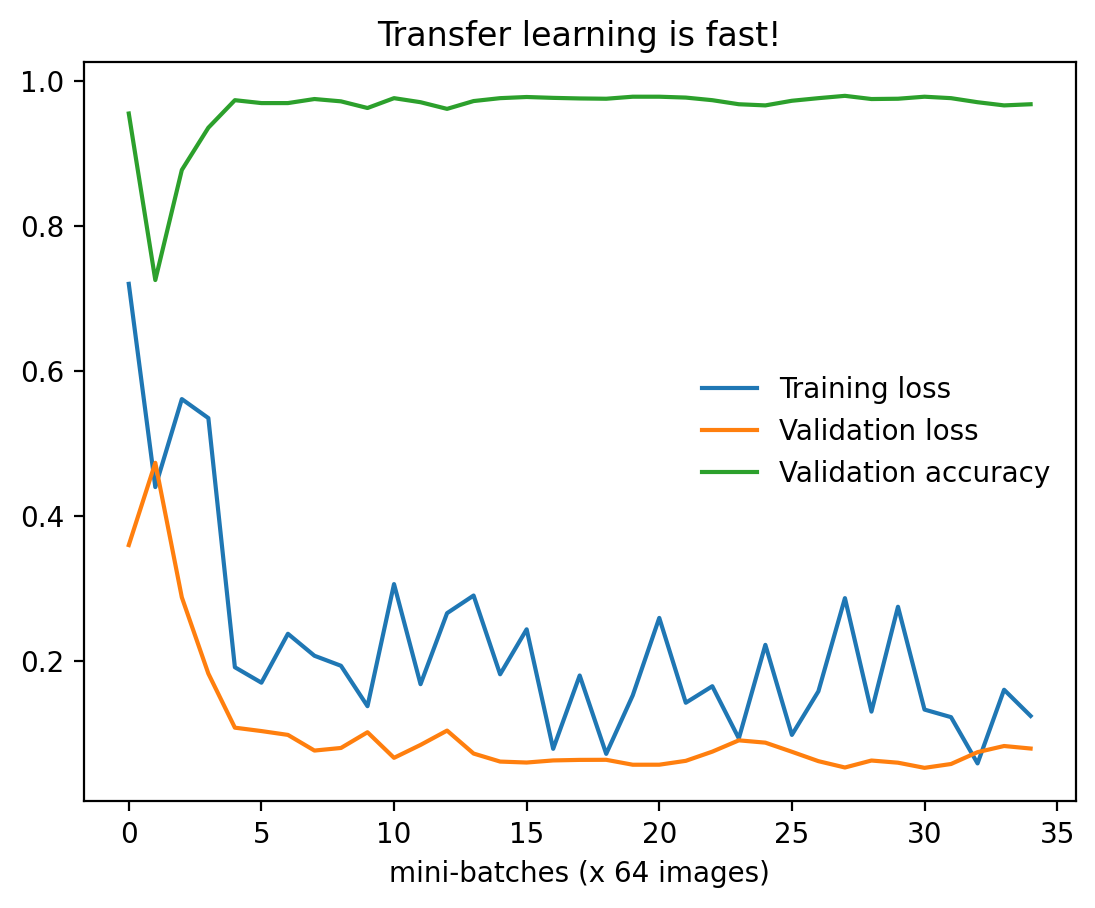

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.plot(test_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('mini-batches (x 64 images)');
plt.title('Transfer learning is fast!');

8 errors with 163 images. => Accuracy: 0.950920245398773


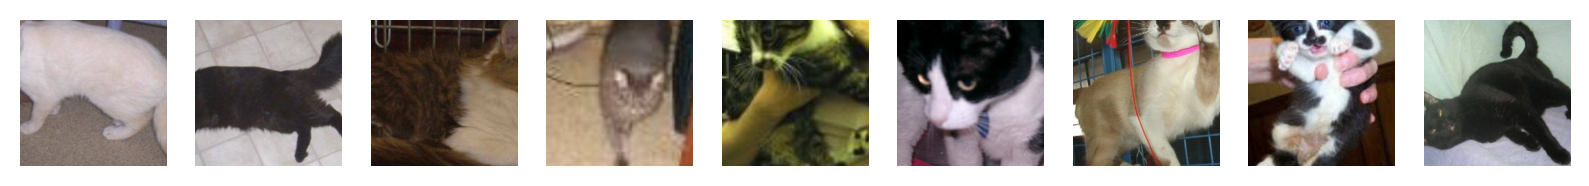

In [17]:
print('8 errors with', last_index, 'images. => Accuracy:', (last_index-8)/last_index)
fig, axes = plt.subplots(figsize=(10,4), ncols=len(error_images))
for ii in range(len(error_images)):
    ax = axes[ii]
    helper.imshow(error_images[ii], ax=ax, normalize=True)

### Great work!